In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!7z x /content/drive/MyDrive/Claheclasses_1.zip


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/drive/MyDrive/                                 1 file, 268015777 bytes (256 MiB)

Extracting archive: /content/drive/MyDrive/Claheclasses_1.zip
 39% 4096 Open              --
Path = /content/drive/MyDrive/Claheclasses_1.zip
Type = zip
Physical Size = 268015777

  0%    
Would you like to replace the existing file:
  Path:     ./Claheclasses_1/1/99_left.jpeg
  Size:     19629 bytes (20 KiB)
  Modified: 2022-11-26 16:01:36
with the file from archive:
  Path:     Claheclasses_1/1/99_left.jpeg
  Size:     19629 bytes (20 KiB)
  Modified: 2022-11-26 16:01:36
? (Y)es / (N)o / (A)lways / (S)kip all / A(u)to rename all / (Q)uit? s

  0% 2    

In [1]:
# import the libraries
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, BatchNormalization, Dropout

import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pathlib
data_dir = '/content/Claheclasses_1'
data_dir = pathlib.Path(data_dir)

In [3]:
image_count = len(list(data_dir.glob('*/*.jpeg')))
print(image_count)

10304


In [4]:
batch_size = 16
img_height = 299
img_width = 299

In [5]:
dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    shuffle = True,
    image_size = (img_height, img_width),
    batch_size = batch_size)

Found 10304 files belonging to 2 classes.


In [6]:
class_names = dataset.class_names
print(class_names)

['0', '1']


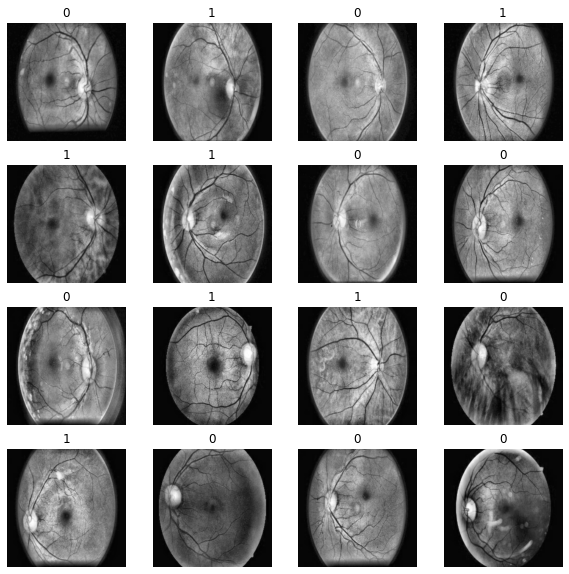

In [7]:
plt.figure(figsize=(10, 10))
for images_batch, labels_batch in dataset.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [8]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10304 files belonging to 2 classes.
Using 7213 files for training.


In [9]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10304 files belonging to 2 classes.
Using 3091 files for validation.


In [10]:
num_classes = len(class_names)

In [11]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model

In [12]:
base_res = model = ResNet50(weights='imagenet', include_top=False)
base_res.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                        

In [13]:
base_res.trainable = False

In [14]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_res(image_batch)
print(feature_batch.shape)

(16, 10, 10, 2048)


In [15]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(16, 2048)


In [16]:
prediction_layer = tf.keras.layers.Dense(8, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(16, 8)


In [17]:
inputs = keras.Input(shape=(img_height, img_width, 3))
x = base_res(inputs, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.05)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [18]:
import time
start_cnn = time.time()

In [19]:
model.compile(optimizer= 'adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

path = 'best_model_res.hdf5'
checkpoint = ModelCheckpoint(path, monitor='val_accuracy', verbose = 1, save_best_only = True, mode='max')
es = EarlyStopping(monitor='val_accuracy', patience=5)

callback_list = [checkpoint,es]

In [21]:
epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs, 
  callbacks=callback_list  
)

Epoch 1/50
451/451 [==============================] - ETA: 0s - loss: 0.7364 - accuracy: 0.5634
Epoch 1: val_accuracy improved from -inf to 0.61501, saving model to best_model_res.hdf5
451/451 [==============================] - 68s 143ms/step - loss: 0.7364 - accuracy: 0.5634 - val_loss: 0.6581 - val_accuracy: 0.6150
Epoch 2/50
451/451 [==============================] - ETA: 0s - loss: 0.6728 - accuracy: 0.6064
Epoch 2: val_accuracy did not improve from 0.61501
451/451 [==============================] - 63s 140ms/step - loss: 0.6728 - accuracy: 0.6064 - val_loss: 0.6762 - val_accuracy: 0.5804
Epoch 3/50
451/451 [==============================] - ETA: 0s - loss: 0.6714 - accuracy: 0.6132
Epoch 3: val_accuracy improved from 0.61501 to 0.62795, saving model to best_model_res.hdf5
451/451 [==============================] - 65s 145ms/step - loss: 0.6714 - accuracy: 0.6132 - val_loss: 0.6418 - val_accuracy: 0.6280
Epoch 4/50
451/451 [==============================] - ETA: 0s - loss: 0.6601 -

In [22]:
scores = model.evaluate(val_ds)

194/194 [==============================] - 21s 106ms/step - loss: 0.6767 - accuracy: 0.6335


In [23]:
scores = model.evaluate(train_ds)

451/451 [==============================] - 48s 106ms/step - loss: 0.5821 - accuracy: 0.6860


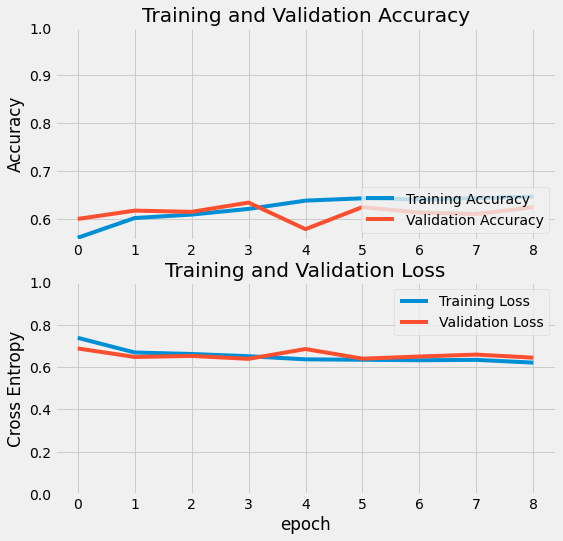

In [26]:
plt.style.use('fivethirtyeight')

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [27]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 21ms/step


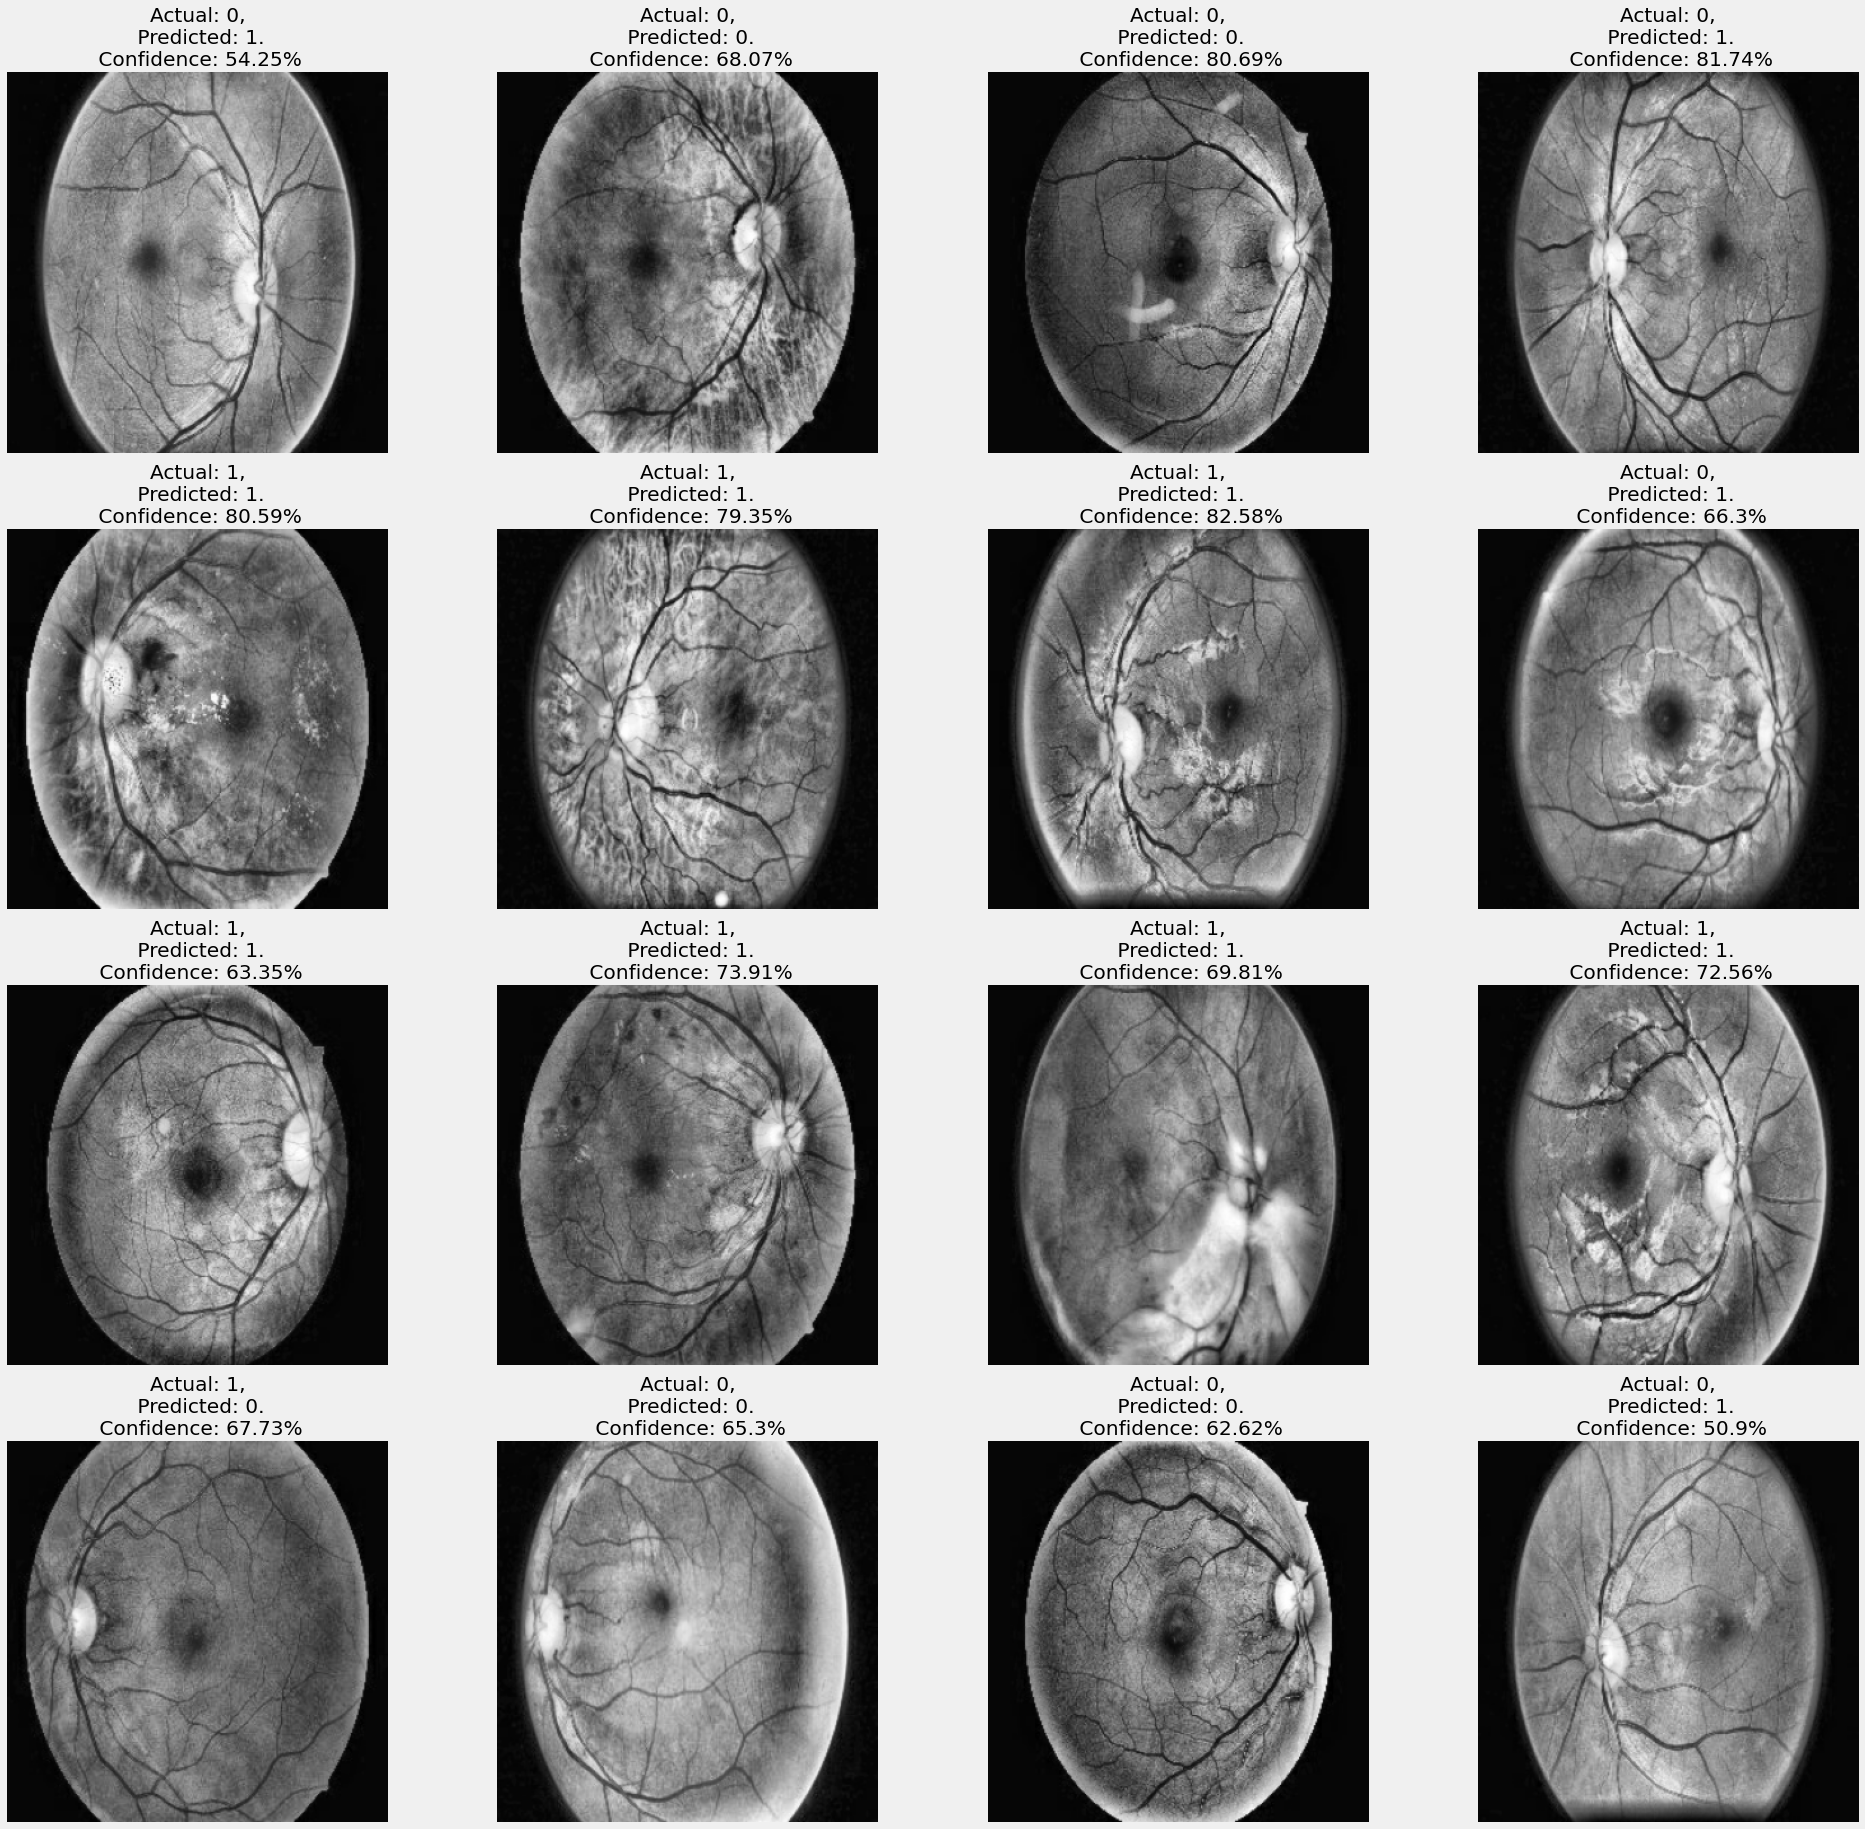

In [28]:
plt.figure(figsize=(30, 30))
for images, labels in val_ds.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")

In [24]:
X = []
y = []
for image,labels in val_ds.take(96):
    for i in image:
        img = i.numpy()
        X.append(img)
    lbl_list = labels.numpy()    
    y.extend(lbl_list)  

In [25]:
x = np.array(X)

In [26]:
y = np.array(y)

In [27]:
x.shape

(1536, 299, 299, 3)

In [33]:
x.shape, y.shape

((3072, 299, 299, 3), (3072,))

In [28]:
model.evaluate(x[:1536],y[:1536])

48/48 [==============================] - 11s 205ms/step - loss: 0.6897 - accuracy: 0.6270


[0.6897144913673401, 0.626953125]

In [29]:
from sklearn.metrics import confusion_matrix , classification_report
import numpy as np
y_pred = model.predict(x[:1536])
y_pred_classes = [np.argmax(element) for element in y_pred]
 
print("Classification Report: \n", classification_report(y[:1536], y_pred_classes))

48/48 [==============================] - 10s 204ms/step
Classification Report: 
               precision    recall  f1-score   support

           0       0.58      0.86      0.69       757
           1       0.75      0.40      0.52       779

    accuracy                           0.63      1536
   macro avg       0.66      0.63      0.61      1536
weighted avg       0.67      0.63      0.61      1536

